# CHE1148 Assignment 1
## Task #1: covid c mortalities cumulative analysis

#### Import all the packages

In [1]:
import pandas as pd
import glob
import os
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from adjustText import adjust_text
from matplotlib.ticker import ScalarFormatter
import warnings
warnings.filterwarnings("ignore")

C:\Programing_Language\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Plot the cases: covid b cases cumulative analysis

The average infection rate is: 6163.3 per 1m people
The average death rate is: 226.8 per 1m people
The average mortality rate is: 3.7 per 100 people infected


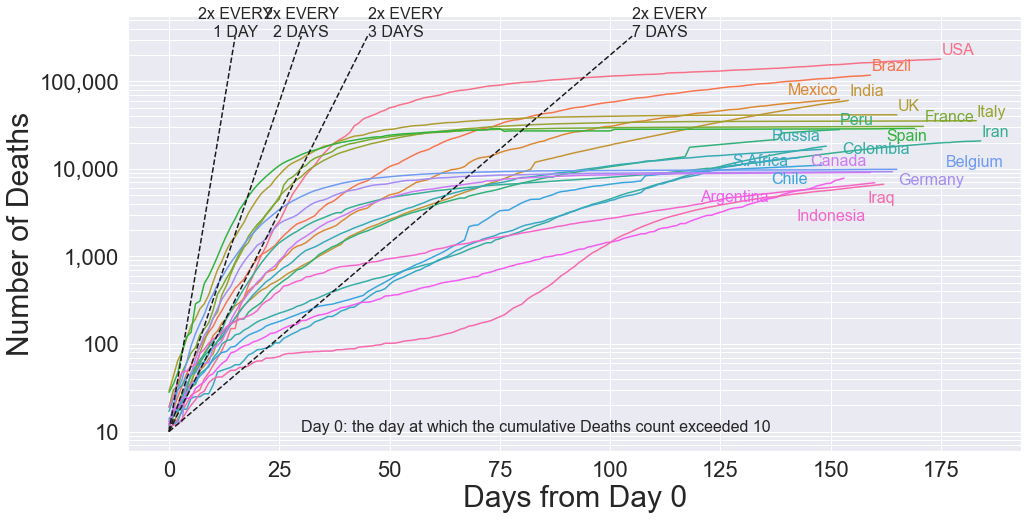

In [2]:
# READ CUMULATIVE TABLE
covid_cumulative = pd.read_excel("covid_a_master_cumulative_table.xlsx")

# This part is necessary instead of simply ['Date'].max() because some countries do not report on certain days (e.g. Spain on Sundays) -- FIXED BUG
last_day_per_country = covid_cumulative.groupby(by=['Countries'])['Date'].max() # type(last_day_per_country) is pandas.Series
last_day_per_country = last_day_per_country.to_frame() # We convert it to pandas.DataFrame
last_day_per_country.reset_index(inplace=True) # And reset the index so that we can further join on 'Countries'

# N: HOW MANY TOP COUNTRIES YOU WANT TO PICK IN TERMS OF # OF CASES
N = 20
last_day = pd.merge(covid_cumulative, last_day_per_country, how='inner', left_on = ['Countries', 'Date'], right_on = ['Countries', 'Date'])
last_day = last_day.sort_values('Deaths', ascending=False)
last_day
top_countries = last_day[:N]['Countries'].tolist()

# K: HOW MANY CASES YOU CONSIDER THE DAY 0
K = 10
covid_top_countries = covid_cumulative[covid_cumulative.Countries.isin(top_countries)]
covid_top_countries = covid_top_countries[covid_top_countries['Deaths'] > K]

# FIND THE DATE THAT THE FIRST K CASES WERE IDENTIFIED
day_0_for_every_country = covid_top_countries.groupby(by=['Countries']).min()
day_0_for_every_country = day_0_for_every_country['Date']

# MERGE THE TWO TO GET THE DAY_0 IN THE df, AND CALCULATE THE DAYS_FROM_0
covid_top_countries = covid_top_countries.merge(day_0_for_every_country, how='inner', on='Countries')
covid_top_countries.rename(columns = {'Date_y': 'Day_0'}, inplace = True)
covid_top_countries['Days_from_0'] = (covid_top_countries['Date_x'] - covid_top_countries['Day_0']).dt.days

max_cases = covid_top_countries.groupby(by=['Countries']).max()
max_cases['Case_fatality_rate'] = max_cases['Deaths']/max_cases['Cases']*100
max_cases.sort_values('Cases', ascending=False)
max_cases['Infection_rate_per_1m'] = max_cases['Cases']/max_cases['Population']*1000000
max_cases['Mortality_rate_per_1m'] = max_cases['Deaths']/max_cases['Population']*1000000
max_cases.drop('Unnamed: 0', axis = 1, inplace = True)
max_cases.to_excel('covid_b_max_cases.xlsx')

# FUNCTION THAT GIVES YOU THE DOUBLING SLOPE OF 1, 2, 3, 7 DAYS
x1 = np.array([0, 15])
x2 = np.array([0, 30])
x3 = np.array([0, 45])
x7 = np.array([0, 105])

y_1 = np.array([K, K*2**(x1[1])])
y_2 = np.array([K, K*2**(x2[1]/2)])
y_3 = np.array([K, K*2**(x3[1]/3)])
y_7 = np.array([K, K*2**(x7[1]/7)])

sns.set(rc={'figure.figsize':(16,8)}, font_scale = 2)
style = dict(size=10, color='gray')

ax = sns.lineplot(x="Days_from_0", y="Deaths", hue="Countries", data=covid_top_countries, markers=True, hue_order=top_countries, legend=False)
ax.set_yscale('log')
plt.grid(True, which='both')
ax.plot(x1, y_1, 'k--')
ax.plot(x2, y_2, 'k--')
ax.plot(x3, y_3, 'k--')
ax.plot(x7, y_7, 'k--')
ax.set_xlabel("Days from Day 0",fontsize=30)
ax.set_ylabel("Number of Deaths",fontsize=30)
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
# plt.xlim([0, 150])
plt.text(30, 10, 'Day 0: the day at which the cumulative Deaths count exceeded {:.0f}'.format(K), fontsize=16)
plt.text(x1.max(), y_1.max(), '2x EVERY\n1 DAY', ha = 'center', fontsize=16)
plt.text(x2.max(), y_2.max(), '2x EVERY\n2 DAYS', ha = 'center', fontsize=16)
plt.text(x3.max(), y_3.max(), '2x EVERY\n3 DAYS', ha = 'left', fontsize=16)
plt.text(x7.max(), y_7.max(), '2x EVERY\n7 DAYS', ha = 'left', fontsize=16)
texts = [plt.text(max_cases.loc[str(country)]['Days_from_0'], max_cases.loc[str(country)]['Deaths'], str(country), fontsize=16, color=ax.get_lines()[top_countries.index(country)].get_c(), ha = 'center', va = 'center') for country in top_countries]
adjust_text(texts)
plt.savefig('Fig_1_1_ZHANG_YANBIN.png')


Average_infection_rate_per_1m = max_cases['Cases'].sum()/max_cases['Population'].sum()*1000000
print("The average infection rate is: {:.1f} per 1m people".format(Average_infection_rate_per_1m))
Average_death_rate_per_1m = max_cases['Deaths'].sum()/max_cases['Population'].sum()*1000000
print("The average death rate is: {:.1f} per 1m people".format(Average_death_rate_per_1m))
Average_mortality_per_cent_infected = max_cases['Deaths'].sum()/max_cases['Cases'].sum()*100
print("The average mortality rate is: {:.1f} per 100 people infected".format(Average_mortality_per_cent_infected))

#### Plot the daily cases moving averages

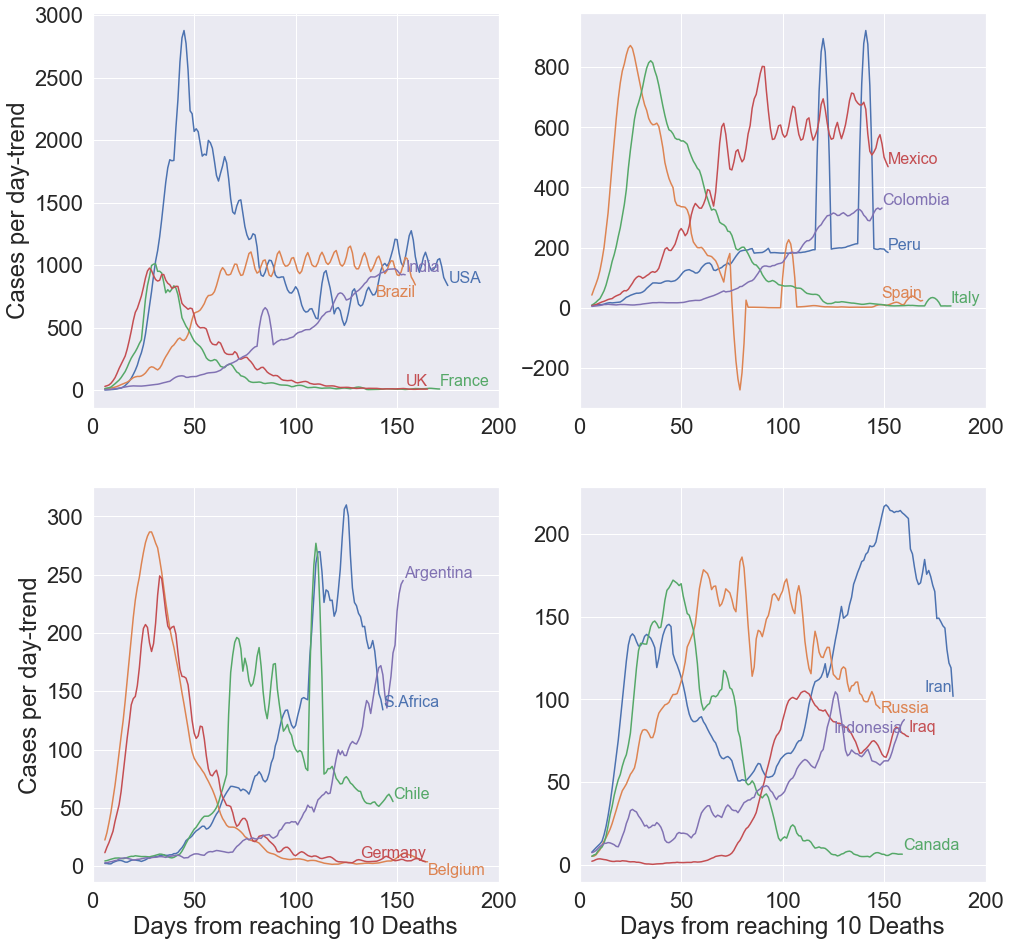

In [3]:
# back_calc IS THE BACK WINDOW THAT IS USED TO CALCULATE THE SLOPE
back_calc = 7
slope_df = pd.DataFrame(columns=['Countries', 'Days_from_0', 'Slope', 'R2', 'P_value'])

for country in top_countries:
    one_country_data = covid_top_countries[covid_top_countries['Countries'] == str(country)].reset_index(drop=True)
#     one_country_data['log_cases'] = np.log10(one_country_data['Cases'])
    for i in np.arange(back_calc, len(one_country_data)+1):
        x = one_country_data.loc[i-back_calc: i, 'Days_from_0'] # That is the 'Days_from_0'
        y = one_country_data.loc[i-back_calc: i, 'Deaths'] # 
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        one_country_data.loc[i-1, 'Slope'] = slope
        one_country_data.loc[i-1, 'R2'] = r_value * r_value
        one_country_data.loc[i-1, 'P_value'] = p_value
        one_country = one_country_data[['Countries', 'Days_from_0', 'Slope', 'R2', 'P_value']]
    
    slope_df = slope_df.append(one_country, ignore_index=False)
    
slope_df.set_index('Countries', drop=False, inplace=True)
slope_df.to_excel('covid_b_slope_daily.xlsx')

slope_df.index.name = None
max_slope = slope_df.groupby(by=['Countries']).max()
max_slope = max_slope.sort_values('Slope', ascending=False)
max_slope['Countries'] = max_slope.index

data_1_5 = slope_df[slope_df.Countries.isin(max_slope[:5]['Countries'].tolist())].reset_index()
countries_1_5 = max_slope[:5]['Countries'].tolist()
data_6_10 = slope_df[slope_df.Countries.isin(max_slope[5:10]['Countries'].tolist())].reset_index()
countries_6_10 = max_slope[5:10]['Countries'].tolist()
data_11_15 = slope_df[slope_df.Countries.isin(max_slope[10:15]['Countries'].tolist())].reset_index()
countries_11_15 = max_slope[10:15]['Countries'].tolist()
data_16_20 = slope_df[slope_df.Countries.isin(max_slope[15:20]['Countries'].tolist())].reset_index()
countries_16_20 = max_slope[15:20]['Countries'].tolist()

sns.set(rc={'figure.figsize':(16,16)}, font_scale = 2)
fig, axes = plt.subplots(2, 2)

sns.lineplot(x="Days_from_0", y="Slope", hue="Countries", data=data_1_5, markers=True, hue_order=countries_1_5, legend=False, ax=axes[0, 0])
texts = [axes[0, 0].text(max_cases.loc[str(country)]['Days_from_0'], slope_df.loc[str(country)]['Slope'].iloc[-1], str(country), fontsize=16, color=axes[0, 0].get_lines()[countries_1_5.index(country)].get_c(), ha = 'left', va = 'center') for country in countries_1_5]
adjust_text(texts)
axes[0, 0].set_ylabel("Cases per day-trend",fontsize=24)

sns.lineplot(x="Days_from_0", y="Slope", hue="Countries", data=data_6_10, markers=True, hue_order=countries_6_10, legend=False, ax=axes[0, 1])
texts = [axes[0, 1].text(max_cases.loc[str(country)]['Days_from_0'], slope_df.loc[str(country)]['Slope'].iloc[-1], str(country), fontsize=16, color=axes[0, 1].get_lines()[countries_6_10.index(country)].get_c(), ha = 'left', va = 'top') for country in countries_6_10]
adjust_text(texts)

sns.lineplot(x="Days_from_0", y="Slope", hue="Countries", data=data_11_15, markers=True, hue_order=countries_11_15, legend=False, ax=axes[1, 0])
texts = [axes[1, 0].text(max_cases.loc[str(country)]['Days_from_0'], slope_df.loc[str(country)]['Slope'].iloc[-1], str(country), fontsize=16, color=axes[1, 0].get_lines()[countries_11_15.index(country)].get_c(), ha = 'left', va = 'center') for country in countries_11_15]
adjust_text(texts)
axes[1, 0].set_ylabel("Cases per day-trend",fontsize=24)
axes[1, 0].set_xlabel("Days from reaching 10 Deaths",fontsize=24)

sns.lineplot(x="Days_from_0", y="Slope", hue="Countries", data=data_16_20, markers=True, hue_order=countries_16_20, legend=False, ax=axes[1, 1])
texts = [axes[1, 1].text(max_cases.loc[str(country)]['Days_from_0'], slope_df.loc[str(country)]['Slope'].iloc[-1], str(country), fontsize=16, color=axes[1, 1].get_lines()[countries_16_20.index(country)].get_c(), ha = 'left', va = 'center') for country in countries_16_20]
adjust_text(texts)
axes[1, 1].set_xlabel("Days from reaching 10 Deaths",fontsize=24)

axes[0, 1].set_ylabel("",fontsize=24)
axes[1, 1].set_ylabel("",fontsize=24)
axes[0, 0].set_xlabel("",fontsize=24)
axes[0, 1].set_xlabel("",fontsize=24)
axes[0, 1].set_xlim([0, 200])
axes[1, 1].set_xlim([0, 200])
axes[0, 0].set_xlim([0, 200])
axes[1, 0].set_xlim([0, 200])
# axes[0, 0].set_yscale('log')
# axes[0, 1].set_yscale('log')
# axes[1, 0].set_yscale('log')
# axes[1, 1].set_yscale('log')

plt.savefig('Fig_1_2_ZHANG_YANBIN.png')

#### Task #1: covid c mortalities cumulative analysis

In [4]:
death_rate = pd.read_excel('Death_rate_crude_per_1000_people.xls',
                           sheet_name = 'Data',
                           header = 3,
                           index_col = 0)\
                           .drop(columns=['Country Code','Indicator Name','Indicator Code'])
death_rate = death_rate.ffill(axis=1).iloc[:,-1]
death_rate = death_rate.to_frame(name = "Death rate per 1000")
death_rate['Countries'] = death_rate.index
death_rate.replace('United States','USA',inplace=True)
death_rate.replace('United Kingdom','UK',inplace=True)
death_rate.replace('Korea, Rep','S.Korea',inplace=True)
death_rate.replace('Iran, Islamic Rep.','Iran',inplace=True)
death_rate.replace('Saudi Arabia','S.Arabia',inplace=True)
death_rate.replace('South Africa','S.Africa',inplace=True)


In [5]:
# READ CUMULATIVE TABLE
covid_cumulative = pd.read_excel("covid_a_master_cumulative_table.xlsx")

# This part is necessary instead of simply ['Date'].max() because some countries do not report on certain days (e.g. Spain on Sundays) -- FIXED BUG
last_day_per_country = covid_cumulative.groupby(by=['Countries'])['Date'].max() # type(last_day_per_country) is pandas.Series
last_day_per_country = last_day_per_country.to_frame() # We convert it to pandas.DataFrame
last_day_per_country.reset_index(inplace=True) # And reset the index so that we can further join on 'Countries'

# N: HOW MANY TOP COUNTRIES YOU WANT TO PICK IN TERMS OF # OF CASES
N = 20
last_day = pd.merge(covid_cumulative, last_day_per_country, how='inner', left_on = ['Countries', 'Date'], right_on = ['Countries', 'Date'])
last_day = last_day.sort_values('Deaths', ascending=False)
last_day
top_countries = last_day[:N]['Countries'].tolist()

# K: HOW MANY DEATHS YOU CONSIDER THE DAY 0
K = 10
covid_top_countries_Day0_from_death_exceed_10 = covid_cumulative[covid_cumulative.Countries.isin(top_countries)]
covid_top_countries_Day0_from_death_exceed_10 = covid_top_countries_Day0_from_death_exceed_10[covid_top_countries_Day0_from_death_exceed_10['Deaths'] > K]

# FIND THE DATE THAT THE FIRST K DEATH WERE IDENTIFIED
day_0_for_every_country = covid_top_countries_Day0_from_death_exceed_10.groupby(by=['Countries']).min()
day_0_for_every_country = day_0_for_every_country['Date']

# MERGE THE TWO TO GET THE DAY_0 IN THE df, AND CALCULATE THE DAYS_FROM_0
covid_top_countries_Day0_from_death_exceed_10 = covid_top_countries_Day0_from_death_exceed_10.merge(day_0_for_every_country, how='inner', on='Countries')
covid_top_countries_Day0_from_death_exceed_10.rename(columns = {'Date_y': 'Day_0'}, inplace = True)
covid_top_countries_Day0_from_death_exceed_10['Days_from_0'] = (covid_top_countries_Day0_from_death_exceed_10['Date_x'] - covid_top_countries_Day0_from_death_exceed_10['Day_0']).dt.days

In [6]:
df = covid_top_countries_Day0_from_death_exceed_10.merge(death_rate, on='Countries', how='left')
df['Typical_deaths_per_day']=df['Death rate per 1000']*df['Population']/1000/365

df['Typical_cumulative_deaths']=(df['Days_from_0']+1)*df['Typical_deaths_per_day']
df['Excess_death_rate']=df['Deaths']/df['Typical_cumulative_deaths']*100

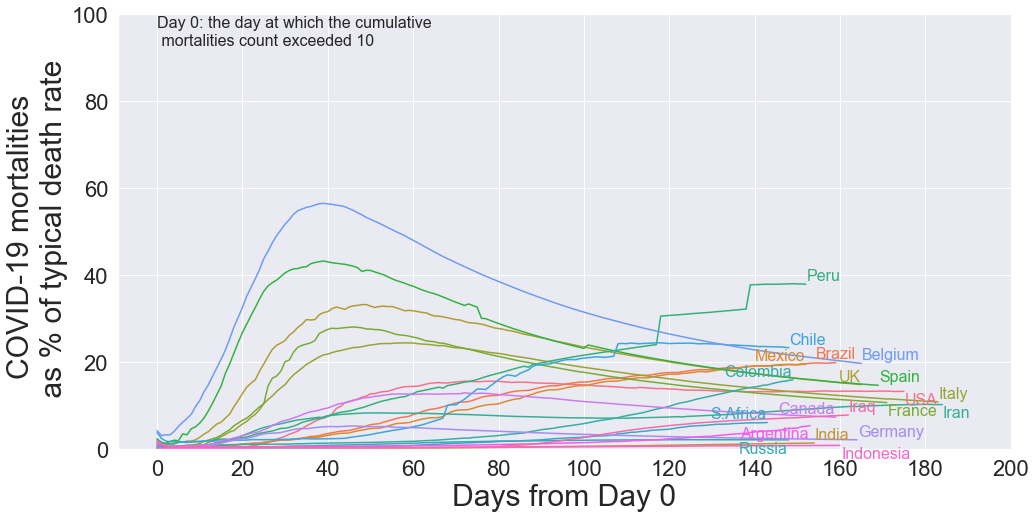

In [7]:
sns.set(rc={'figure.figsize':(16,8)}, font_scale = 2)

ax = sns.lineplot(x="Days_from_0",y='Excess_death_rate',hue="Countries",data=df, markers=True, hue_order=top_countries, legend=False)
texts = [plt.text(list(df[df['Countries']==str(country)]['Days_from_0'])[-1], list(df[df['Countries']==str(country)]['Excess_death_rate'])[-1], str(country), fontsize=16, color=ax.get_lines()[top_countries.index(country)].get_c(), ha = 'center', va = 'center') for country in top_countries]
adjust_text(texts)

ax.set_xlabel("Days from Day 0",fontsize=30)
ax.set_ylabel("COVID-19 mortalities \n as % of typical death rate",fontsize=30)

plt.ylim((0,100))
my_x_ticks=np.arange(0,220,20)
plt.xticks(my_x_ticks)
plt.text(0, 93, 'Day 0: the day at which the cumulative \n mortalities count exceeded {:.0f}'.format(K), fontsize=16)

plt.savefig('Fig_1_3_ZHANG_YANBIN.png')